<center> <h1>Лекция 10</h1>

<h2>MPC: Model Predictive Control</h2>
<h2><i>Управление с прогнозирующими моделями</i></h2>
_________________________________________________________________________________________________________</center>

<div align="right"> Конспект выполнили: Чиркина Алина и Епифанова Виктория </div>

 <b>MPC</b> - это расширенный метод управления процессом, который используется для управления процессом при соблюдении набора ограничений. Используется во множестве отраслей, в моделях балансировки энергосистем и в силовой электронике, применяется различных автопилотах (<i>прим.:</i> беспилотные машины). <b>DMC (Dynamic Matrix Control)</b> и <b>GPC (Generalized Predictive Control)</b> являются классическими примерами  <b>MPC</b>.


Пусть задана задача управления.

Система ДУ, описывающая поведение той системы, которой мы хотим управлять:
$$
\left\{
    \begin{array}\\
        x' = F(x, u, t) \\
        u \in U \\
        Ф(x_k, t_k) \longrightarrow \underset{u}{max}
    \end{array}
\right.
$$

Запустим нашу систему в следующий цикл:
<div><img src="https://raw.githubusercontent.com/plusmortquevivant/stock/main/diagram.png" width="800"/></div>
Мы берём из этой системы выходы, прогоняем через блок оптимизации и возвращаем управление.

### Как это работает?
<b>MPC</b> основан на итеративной оптимизации модели объекта управления на конечном горизонте. В момент времени $t$ производится выбор текущего состояния объекта и вычисляется стратегия управления минимизацией затрат (с помощью алгоритма численной минимизации) для относительно короткого временного горизонта в будущем: $[t, t + T]$.

<div><img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs00542-019-04634-6/MediaObjects/542_2019_4634_Fig3_HTML.png" width="500"/></div>
, где
    <li><p>$X_r(t)$ - referenced trajectory</p>
    <li><p>$X_p(t)$ - predicted output</p>
    <li><p>$\, u(t)\,\,\,$  - predicted control output</p></li>

Т. е. промоделируем систему на $p$ (или, согласно изображению, $T$) тактов c каким-то управлением. Мы хотим, чтобы на этих нескольких тактах просчитывалось движение в соответствии с моделью.
        
Как выбрать $u$, чтобы оптимизация была максимальна?
        
Преобразуем: $x' = F(x, u, t) \longrightarrow \underset{\underset{\underset{u}{maxФ}}{u \,\in\, U}}{\phi(x', x, u, t)} = 0$

Реализуется только первый шаг стратегии управления, затем снова производится выборка состояния объекта и вычисления повторяются, начиная с нового текущего состояния, что дает новый элемент управления и новый прогнозируемый путь состояния. Горизонт планирования продолжает сдвигаться вперед.

Строим $\underset{оптимальное}{u^*(t)}$ - решение задачи оптимизации.

Мы рассчитываем всё управление на всё время прогнозирования и хотим получить линеаризованную модель (линейное программирование, квадратичное программирование с линейным ограничением). В этом смысле <b>MPC</b> схож с <b>SDRE</b>.
<b>MPC</b>, в отличие от <b>LQR</b>, гораздо лучше учитывает ограничения, которые накладываюются на управление.
<div><img "src=https://github.com/plusmortquevivant/stock/blob/main/photo_2021-11-07%2017.25.18.jpeg?raw=true" width="500"/></div>
<b>MPC</b> занимается условной оптимизацией ровно в ой области управления, где поставлена задача.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from scipy.optimize import minimize

In [2]:
# Define process model
def process_model(y, t, u, K, tau):
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant

    # calculate derivative
    dydt = (-y + K * u)/(tau)

    return dydt

In [3]:
# Define Objective function      
def objective(u_hat):
    # Prediction
    for k in range(1, 2 * P + 1):
        if k == 1:
            y_hat0 = yp[i-P]

        if k <= P:
            if i - P + k < 0:
                u_hat[k] = 0

            else:
                u_hat[k] = u[i-P+k]

        elif k > P + M:
            u_hat[k] = u_hat[P+M]

        ts_hat = [delta_t_hat * (k-1), delta_t_hat * (k)]        
        y_hat = odeint(process_model, y_hat0, ts_hat, args=(u_hat[k], K, tau))
        y_hat0 = y_hat[-1]
        yp_hat[k] = y_hat[0]

        # Squared Error calculation
        sp_hat[k] = sp[i]
        delta_u_hat = np.zeros(2*P+1)        

        if k > P:
            delta_u_hat[k] = u_hat[k] - u_hat[k-1]
            se[k] = (sp_hat[k] - yp_hat[k])**2 + 20 * (delta_u_hat[k])**2

    # Sum of Squared Error calculation      
    obj = np.sum(se[P+1:])
    return obj 

<Figure size 720x432 with 0 Axes>

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.17841291427612305
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.14426088333129883
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.1518089771270752
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.1448040008544922
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.14960002899169922
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.15465688705444336
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.15467524528503418
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.1477959156036377
Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.18276596069335938
Initial SSE Objective: 750.0
Final SSE Objective: 105.66128568284341
Elapsed time: 3.1494221687316895
Initial SSE Objective: 213.560608827858
Final SSE Objective: 62.66861834210718
Elapsed time: 3.0199596881866455
Initial SSE Obj

Final SSE Objective: 6.825889252392082e-06
Elapsed time: 1.3604040145874023
Initial SSE Objective: 5.2607029222286476e-05
Final SSE Objective: 3.650705166874101e-06
Elapsed time: 1.2986538410186768
Initial SSE Objective: 4.449917732325568e-05
Final SSE Objective: 1.7897260433692148e-06
Elapsed time: 1.3165159225463867
Initial SSE Objective: 3.219597009633459e-05
Final SSE Objective: 1.3039669960457578e-06
Elapsed time: 1.023880958557129
Initial SSE Objective: 2.019894965545018e-05
Final SSE Objective: 9.282863697251604e-07
Elapsed time: 0.9901769161224365
Initial SSE Objective: 1.0681213355342579e-05
Final SSE Objective: 1.1356752820552368e-06
Elapsed time: 0.7111959457397461
Initial SSE Objective: 1470.174225455291
Final SSE Objective: 207.1182888868417
Elapsed time: 3.991084098815918
Initial SSE Objective: 606.5458656093606
Final SSE Objective: 140.43437632195452
Elapsed time: 3.6533761024475098
Initial SSE Objective: 147.45537815785497
Final SSE Objective: 79.67811455970929
Elapsed 

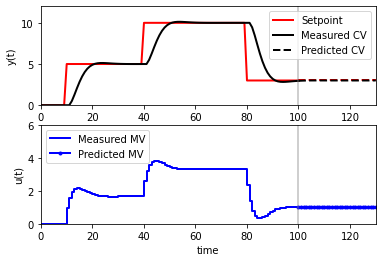

In [4]:
# FOPDT Parameters
K = 3.0      # gain
tau = 5.0    # time constant
ns = 100    # Simulation Length
t = np.linspace(0, ns, ns+1)
delta_t = t[1] - t[0]

# Define horizons
P = 30 # Prediction Horizon
M = 10  # Control Horizon

# Input Sequence
u = np.zeros(ns + 1)

# Setpoint Sequence
sp = np.zeros(ns + 1 + 2 * P)
sp[10:40] = 5
sp[40:80] = 10
sp[80:] = 3

# Controller setting
maxmove = 1

## Process simulation
yp = np.zeros(ns + 1)

#  Create plot
plt.figure(figsize = (10,6))
plt.ion()
plt.show()

for i in range(1, ns + 1):
    if i == 1:
        y0 = 0
        
    ts = [delta_t * (i-1), delta_t * i]
    y = odeint(process_model, y0, ts, args=(u[i], K, tau))
    y0 = y[-1]
    yp[i] = y[0]

    # Declare the variables in fuctions
    t_hat = np.linspace(i-P, i+P, 2 * P + 1)
    delta_t_hat = t_hat[1] - t_hat[0]
    se = np.zeros(2 * P + 1)
    yp_hat = np.zeros(2 * P + 1)
    u_hat0 = np.zeros(2 * P + 1)
    sp_hat = np.zeros(2 * P + 1)
    obj = 0.0

    # initial guesses
    for k in range(1, 2 * P + 1):

        if k <= P:
            if i - P + k < 0:
                u_hat0[k] = 0
            else:
                u_hat0[k] = u[i - P + k]

        elif k > P:
            u_hat0[k] = u[i]

    # show initial objective
    print('Initial SSE Objective: ' + str(objective(u_hat0)))

    # MPC calculation
    start = time.time()

    solution = minimize(objective, u_hat0, method='SLSQP')
    u_hat = solution.x  

    end = time.time()
    elapsed = end - start

    print('Final SSE Objective: ' + str(objective(u_hat)))
    print('Elapsed time: ' + str(elapsed) )

    delta = np.diff(u_hat)

    if i < ns:    
        if np.abs(delta[P]) >= maxmove:
            if delta[P] > 0:
                u[i + 1] = u[i] + maxmove
            else:
                u[i + 1] = u[i] - maxmove

        else:
            u[i+1] = u[i] + delta[P]

    # plotting for forced prediction
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.plot(t[0:i+1], sp[0:i+1], 'r-', linewidth=2, label='Setpoint')
    plt.plot(t_hat[P:], sp_hat[P:], 'r--', linewidth=2)
    plt.plot(t[0:i+1], yp[0:i+1], 'k-',linewidth=2, label='Measured CV')
    plt.plot(t_hat[P:],yp_hat[P:], 'k--', linewidth=2, label='Predicted CV')
    plt.axvline(x=i, color='gray', alpha=0.5)
    plt.axis([0, ns+P, 0, 12])
    plt.ylabel('y(t)')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t[0:i+1], u[0:i+1], 'b-', linewidth=2, label='Measured MV')
    plt.plot(t_hat[P:], u_hat[P:], 'b.-', linewidth=2, label='Predicted MV')
    plt.axvline(x=i, color='gray', alpha=0.5)
    plt.ylabel('u(t)')
    plt.xlabel('time')
    plt.axis([0, ns+P, 0, 6])
    plt.legend()
    plt.draw()